In [35]:
import os
import sys
sys.path.append('../../')
from modules.data_import import *
from modules.basics import *
from modules.features import *

from lumin.nn.callbacks.data_callbacks import ParametrisedPrediction

%matplotlib inline
%reload_ext autoreload
%autoreload 2
import uproot3
import pandas as pd
import matplotlib.pyplot as plt
from fastprogress import progress_bar, master_bar
import copy
from typing import Callable, Tuple
import json

from sklearn.model_selection import train_test_split

In [36]:
run_name = '11-24-2021'

In [37]:
ensemble_0 = Ensemble.from_save(f'weights/selected_set_0_{run_name}')
ensemble_1 = Ensemble.from_save(f'weights/selected_set_1_{run_name}')

In [38]:
PATH = Path('../../../MC/')

In [39]:
res_mass = [900]

In [40]:
PATH = Path('../../../MC')
signal = {'GluGluToRadionToHHTo2B2ZTo2L2J_M-'+str(i)+'_narrow_13TeV-madgraph-v2': uproot3.open(PATH/('GluGluToRadionToHHTo2B2ZTo2L2J_M-'+str(i)+'_narrow_13TeV-madgraph-v2.root'))["Events"] for i in res_mass}
# background = {i: uproot3.open(PATH/(i+'.root'))["Events"] for i in\
#               ['DYJetsToLL_M-10to50_TuneCUETP8M1_13TeV-amcatnloFXFX-pythia8', 'DYToLL_0J_13TeV-amcatnloFXFX-pythia8',\
#                'DYToLL_1J_13TeV-amcatnloFXFX-pythia8','DYToLL_2J_13TeV-amcatnloFXFX-pythia8']}
# print(background)
signal

{'GluGluToRadionToHHTo2B2ZTo2L2J_M-900_narrow_13TeV-madgraph-v2': <TTree b'Events' at 0x02ea31d240d0>}

In [41]:
feats = ["Higgsbb_cand_pt","Zjet_cand_pt",
            "leading_Hbb_pt","trailing_Hbb_pt","leading_jet_pt","trailing_jet_pt",
             "Higgsbb_cand_mass","HiggsZZ_cand_mass","Zlep_cand_mass",
             "Zjet_cand_mass","Zlep_cand_pt",         
             "dR_l1j1","dR_l1j2","dR_l1b1","dR_l1b2",
             "dR_l2j1","dR_l2j2","dR_l2b1","dR_l2b2",
             "dR_j1j2","dR_b1b2"]

# these are the extra variables (outside the selected variables) used for preselection cut
pre_feats = ["ngood_bjets", "leading_lep_pt", "trailing_lep_pt", "lep_category"]

In [42]:
# create signal DataFrame
for i, tree in enumerate(signal.values()):
    if i == 0:
        pre_sig_df = tree.pandas.df(feats+pre_feats)
        pre_sig_df['res_mass'] = res_mass[i]
    else:
        add_df = tree.pandas.df(feats+pre_feats)
        add_df['res_mass'] = res_mass[i]
        pre_sig_df = pre_sig_df.append(add_df, ignore_index=True)
print('shape of signal df before preselection cuts: {}'.format(pre_sig_df.shape))

shape of signal df before preselection cuts: (65639, 26)


In [43]:
sig_df = pd.DataFrame(pre_sig_df.loc[(pre_sig_df.ngood_bjets > 0) & (pre_sig_df.lep_category == 2) & (pre_sig_df.Zlep_cand_mass > 15) &
                                     (pre_sig_df.leading_lep_pt > 20) & (pre_sig_df.trailing_lep_pt > 10) & (pre_sig_df.leading_Hbb_pt > 20) &
                                     (pre_sig_df.trailing_Hbb_pt > 20) & (pre_sig_df.leading_jet_pt > 20) & (pre_sig_df.trailing_jet_pt > 20)])

# drop preselection features that are not in our desired features
sig_df.drop(columns=[f for f in pre_feats], inplace=True)
# bkg_df.drop(columns=[f for f in pre_feats], inplace=True)

print('shape of signal df after preselection cuts: {}'.format(sig_df.shape))
# print('shape of background df after preselection cuts: {}'.format(bkg_df.shape
sig_df.head()

shape of signal df after preselection cuts: (36413, 22)


,Higgsbb_cand_pt,Zjet_cand_pt,leading_Hbb_pt,trailing_Hbb_pt,leading_jet_pt,trailing_jet_pt,Higgsbb_cand_mass,HiggsZZ_cand_mass,Zlep_cand_mass,Zjet_cand_mass,...,dR_l1j2,dR_l1b1,dR_l1b2,dR_l2j1,dR_l2j2,dR_l2b1,dR_l2b2,dR_j1j2,dR_b1b2,res_mass
entry,,,,,,,,,,,,,,,,,,,,,
1,470.274078,69.387245,197.698395,281.912811,68.283752,56.930706,144.301208,308.775360,51.124199,106.675987,...,0.508707,2.649336,3.062102,1.641656,0.637177,3.062136,2.843800,1.993926,0.566757,900
2,375.418915,71.730560,103.911789,280.417694,51.486023,31.303640,96.344688,296.791565,81.792267,68.787354,...,0.539379,2.917649,2.422785,2.091218,0.467008,2.385195,1.885081,1.646023,0.526729,900
4,508.262238,139.129593,270.960388,462.437012,124.875504,78.482559,621.973267,604.346436,92.035095,181.038681,...,1.379122,2.158625,2.594162,2.842100,1.852190,2.624687,2.122317,1.951550,1.898677,900
5,405.033081,20.930138,342.810577,67.703186,46.823524,42.669544,134.217072,292.647858,91.762306,94.201126,...,0.441445,2.963690,2.970528,2.497824,0.837069,2.879490,2.689666,2.781203,0.831057,900
6,144.603714,69.748596,112.283226,33.257378,37.629398,35.917488,48.743980,137.288315,31.433678,45.852699,...,0.569778,3.629981,3.933781,1.271678,0.724459,3.411037,3.674039,1.136367,0.692858,900


In [44]:
# sig_df['Label'] = 1
# bkg_df['Label'] = 0

# df = sig_df[:].append(bkg_df[:], ignore_index=True)
sig_df.rename(index=str, columns={'weight_central':'gen_weight'}, inplace=True)

# add weights=1 for now
sig_df['gen_weight'] = 1
# add_bkg_res_mass(df); df

In [45]:
targ_feat = 'gen_target'
gen_feats = [f for f in sig_df.columns if 'gen_' in f]
misc_feats = []
wgt_feat = 'gen_weight'
cat_feats = []
cont_feats = [f for f in sig_df.columns if f not in gen_feats+cat_feats+misc_feats]
print(len(cat_feats), cat_feats)
print(len(cont_feats), cont_feats)
train_feats = cont_feats + cat_feats
train_feats

0 []
22 ['Higgsbb_cand_pt', 'Zjet_cand_pt', 'leading_Hbb_pt', 'trailing_Hbb_pt', 'leading_jet_pt', 'trailing_jet_pt', 'Higgsbb_cand_mass', 'HiggsZZ_cand_mass', 'Zlep_cand_mass', 'Zjet_cand_mass', 'Zlep_cand_pt', 'dR_l1j1', 'dR_l1j2', 'dR_l1b1', 'dR_l1b2', 'dR_l2j1', 'dR_l2j2', 'dR_l2b1', 'dR_l2b2', 'dR_j1j2', 'dR_b1b2', 'res_mass']


['Higgsbb_cand_pt',
 'Zjet_cand_pt',
 'leading_Hbb_pt',
 'trailing_Hbb_pt',
 'leading_jet_pt',
 'trailing_jet_pt',
 'Higgsbb_cand_mass',
 'HiggsZZ_cand_mass',
 'Zlep_cand_mass',
 'Zjet_cand_mass',
 'Zlep_cand_pt',
 'dR_l1j1',
 'dR_l1j2',
 'dR_l1b1',
 'dR_l1b2',
 'dR_l2j1',
 'dR_l2j2',
 'dR_l2b1',
 'dR_l2b2',
 'dR_j1j2',
 'dR_b1b2',
 'res_mass']

##### From training - 22 Continuous: ['Higgsbb_cand_pt', 'Zjet_cand_pt', 'leading_Hbb_pt', 'trailing_Hbb_pt', 'leading_jet_pt', 'trailing_jet_pt', 'Higgsbb_cand_mass', 'HiggsZZ_cand_mass', 'Zlep_cand_mass', 'Zjet_cand_mass', 'Zlep_cand_pt', 'dR_l1j1', 'dR_l1j2', 'dR_l1b1', 'dR_l1b2', 'dR_l2j1', 'dR_l2j2', 'dR_l2b1', 'dR_l2b2', 'dR_j1j2', 'dR_b1b2', 'res_mass']

In [46]:
sig_df.head()

,Higgsbb_cand_pt,Zjet_cand_pt,leading_Hbb_pt,trailing_Hbb_pt,leading_jet_pt,trailing_jet_pt,Higgsbb_cand_mass,HiggsZZ_cand_mass,Zlep_cand_mass,Zjet_cand_mass,...,dR_l1b1,dR_l1b2,dR_l2j1,dR_l2j2,dR_l2b1,dR_l2b2,dR_j1j2,dR_b1b2,res_mass,gen_weight
entry,,,,,,,,,,,,,,,,,,,,,
1,470.274078,69.387245,197.698395,281.912811,68.283752,56.930706,144.301208,308.775360,51.124199,106.675987,...,2.649336,3.062102,1.641656,0.637177,3.062136,2.843800,1.993926,0.566757,900,1
2,375.418915,71.730560,103.911789,280.417694,51.486023,31.303640,96.344688,296.791565,81.792267,68.787354,...,2.917649,2.422785,2.091218,0.467008,2.385195,1.885081,1.646023,0.526729,900,1
4,508.262238,139.129593,270.960388,462.437012,124.875504,78.482559,621.973267,604.346436,92.035095,181.038681,...,2.158625,2.594162,2.842100,1.852190,2.624687,2.122317,1.951550,1.898677,900,1
5,405.033081,20.930138,342.810577,67.703186,46.823524,42.669544,134.217072,292.647858,91.762306,94.201126,...,2.963690,2.970528,2.497824,0.837069,2.879490,2.689666,2.781203,0.831057,900,1
6,144.603714,69.748596,112.283226,33.257378,37.629398,35.917488,48.743980,137.288315,31.433678,45.852699,...,3.629981,3.933781,1.271678,0.724459,3.411037,3.674039,1.136367,0.692858,900,1


In [72]:
np_arr_0 = sig_df[::2].to_numpy()
np_arr_1 = sig_df[1::2].to_numpy()

# Predict using numpy array

In [58]:
sig_df.columns
sig_df.columns.get_loc('res_mass')

21

In [62]:
def preprocess_mass(m, pipe):
    #idx = set_0_fy.cont_feats.index('res_mass')
    idx = sig_df.columns.get_loc('res_mass')
    m -= pipe[0].mean_[idx]
    m /= pipe[0].scale_[idx]
    return m

### Try using preprocessed mass from each ensemble pipes

In [63]:
mass_param_0 = ParametrisedPrediction(train_feats, ['res_mass'], [preprocess_mass(900,ensemble_0.input_pipe)])
mass_param_1 = ParametrisedPrediction(train_feats, ['res_mass'], [preprocess_mass(900,ensemble_1.input_pipe)])
# mass_param_0 = ParametrisedPrediction(train_feats, ['res_mass'], 900)
# mass_param_1 = ParametrisedPrediction(train_feats, ['res_mass'], 900)
pred_0 = ensemble_0.predict(np_arr_1, cbs=[mass_param_0])
pred_1 = ensemble_1.predict(np_arr_0, cbs=[mass_param_1])
# pred_0 = ensemble_0.predict(np_arr_1)
# pred_1 = ensemble_1.predict(np_arr_0)
pred = np.concatenate((pred_0, pred_1), axis=0)

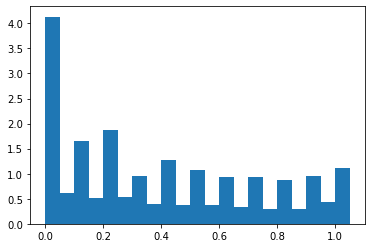

In [64]:
bins = np.arange(0,1.1,0.05)

hist,bins = np.histogram(pred,bins=bins)  
plt.hist(pred, bins = bins, density=1) 
plt.show()

### Try not using preprocessed mass

In [55]:
mass_param_0 = ParametrisedPrediction(train_feats, ['res_mass'], 900)
mass_param_1 = ParametrisedPrediction(train_feats, ['res_mass'], 900)
pred_0 = ensemble_0.predict(np_arr_1, cbs=[mass_param_0])
pred_1 = ensemble_1.predict(np_arr_0, cbs=[mass_param_1])
# pred_0 = ensemble_0.predict(np_arr_1)
# pred_1 = ensemble_1.predict(np_arr_0)
pred = np.concatenate((pred_0, pred_1), axis=0)

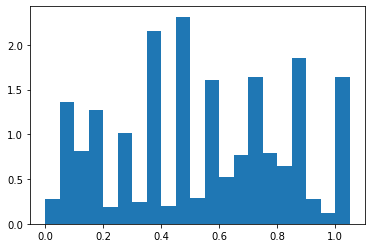

In [56]:
bins = np.arange(0,1.1,0.05)

hist,bins = np.histogram(pred,bins=bins)  
plt.hist(pred, bins = bins, density=1) 
plt.show()

### Try using transformed input

In [97]:
with open(PATH/"input_pipe_0_untrained.pkl", 'rb') as pickle_file:
    input_pipe_0 = pickle.load(pickle_file)

with open(PATH/"input_pipe_1_untrained.pkl", 'rb') as pickle_file:
    input_pipe_1 = pickle.load(pickle_file)
    
transformed_input_0 = np.hstack((input_pipe_0.inverse_transform(np_arr_0[:,:len(cont_feats)]), np_arr_0[:,len(cont_feats):]))
transformed_input_1 = np.hstack((input_pipe_1.inverse_transform(np_arr_1[:,:len(cont_feats)]), np_arr_1[:,len(cont_feats):]))

In [98]:
pred_0 = ensemble_0.predict(transformed_input_0)
pred_1 = ensemble_1.predict(transformed_input_1)
pred = np.concatenate((pred_0, pred_1), axis=0)

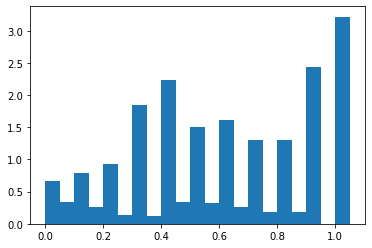

In [99]:
bins = np.arange(0,1.1,0.05)

hist,bins = np.histogram(pred,bins=bins)  
plt.hist(pred, bins = bins, density=1) 
plt.show()